# Chapter 8: Conditional GAN

Conditional GAN is a GAN variant presented in the paper [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) by *Mehdi Mirza* and *Simon Osindero*. This architecture allows to direct the generator what samples to create.

The provided example in this notebook is using the MNIST dataset to train a generator and allows to tell the generator what number should be generated. The CGAN has the follwing architecture.
![Architecture](img/architecture.png)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.cuda as cuda
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Lambda

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Loading data

We use the PyTorch data loading capabilities and define the function `get_z_vector` to get a latent vector $z$ of the desired length.

The PyTorch `torchvision` package provides a convenient way to access the MNIST dataset. The images in the dataset come in the range $\left[0, 255\right]$ and are first converted to a tensor in the range $\left[0.0, 1.0\right]$ and finally normalized with `Lambda` to be in $\left[-1.0, +1.0\right]$. The `DataLoader` class is used to iterate through the dataset and assembles the batches of size 32 and shuffles the access.

In [2]:
# A transform which results that the images are in the desired range
trans = Compose([ToTensor(), Lambda(lambda x: x * 2 - 1)])

# The actual MNIST dataset on which the transformation is applied
train_set = MNIST('~/pytorch', train=True, transform=trans, download=True)

# The DataLoader which provides us batches of 32 data samples
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

# Function to get the latent vector z
def get_z_vector(batch_size, length):
    return torch.randn(batch_size, length)

# Support CUDA

In PyTorch GPU (CUDA) support is done explicitly by moving the tensors to the device. Therefore, we define the variable `device` which is used in the following code to execute the tensors on the GPU or CPU.

In [3]:
if cuda.is_available():
    print("Using cuda device for training")
    device = 'cuda'
else:
    print("Using cpu for training")
    device = 'cpu'

Using cuda device for training


# Generator
![Generator](img/generator.png)

In [4]:
class Generator(nn.Module):
    def __init__(self, num_classes, z_dim):
        super().__init__()
        self.embed = nn.Embedding(num_classes, z_dim)
        self.dense = nn.Linear(z_dim, 7 * 7 * 256)
        self.trans1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU())
        self.trans2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU())
        self.trans3 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh())
        
    def forward(self, z, label):
        embedded_label = self.embed(label)
        x = embedded_label * z
        x = self.dense(x).view(-1, 256, 7, 7)
        x = self.trans1(x)
        x = self.trans2(x)
        x = self.trans3(x)
        
        return x

# Discriminator

The descriminator converts the inputs $(x, y)$ into a prediction $\sigma$, which is the probablity that the input is sampled from a real distribution $p_{data}$. The architecture is shown in the image below.

![Discriminator](img/discriminator.png)

The discriminator embeds the label $embed(y)$ and concatinates it with the image $x$. After that, three `Conv2d` layers with `LeakyReLU` activation and `BatchNorm2d` follow. Note that the fist layer does not use batch normalization.

At the end of the network a `Linear` layer is used with `Sigmoid` activation.

In [5]:
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size):
        super().__init__()
        self.width = img_size[0]
        self.height = img_size[1]
        
        self.embed = nn.Embedding(10, self.width * self.height)
        self.conv1 = nn.Sequential(
            nn.Conv2d(2, 64, 3, stride=2, padding=1),
            nn.LeakyReLU())
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU())
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU())
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 3 * 128, 1),
            nn.Sigmoid())
        
    def forward(self, x, label):
        embedded_label = self.embed(label).view(-1, 1, 28, 28)
        x = torch.cat([x, embedded_label], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.dense(x)
        
        return x

# Training

In [6]:
generator = Generator(10, 100).to(device)
discriminator = Discriminator(10, (28, 28)).to(device)
g_optim = optim.Adam(generator.parameters(), lr=0.001)
d_optim = optim.Adam(discriminator.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [9]:
y_real = torch.ones(batch_size, 1).to(device)
y_fake = torch.zeros(batch_size, 1).to(device)

for epoch in range(100):
    for x, labels in tqdm(train_loader):
        x = x.to(device)
        labels = labels.to(device)
        d_out = discriminator(x, labels)
        d_loss_real = criterion(d_out, y_real)

        d_optim.zero_grad()
        d_loss_real.backward()
        d_optim.step()

        x_gen = generator(get_z_vector(batch_size, 100).to(device), labels)
        d_out = discriminator(x_gen, labels)
        d_loss_fake = criterion(d_out, y_fake)
        
        d_optim.zero_grad()
        d_loss_fake.backward()
        d_optim.step()
        
        x_gen = generator(get_z_vector(batch_size, 100).to(device), labels)
        d_out = discriminator(x_gen, labels)
        g_loss = criterion(d_out, y_real)
        
        g_optim.zero_grad()
        g_loss.backward()
        g_optim.step()
        
    print(f"D-Loss: {d_loss_real + d_loss_fake:.4} G-Loss: {g_loss:.4}")
    sample_images(generator)
    

KeyboardInterrupt: 

In [ ]:
def sample_images(generator, image_grid_rows=2, image_grid_columns=5):
    # Sample random noise
    z = get_z_vector(image_grid_rows * image_grid_columns, 100).to(device)

    # Generate images from random noise
    with torch.no_grad():
        generator.eval()
        gen_imgs = generator(z, torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device=device)).cpu().detach().view(-1, 28, 28).numpy()
        generator.train()

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(6, 3),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

In [ ]:
sample_images(generator)

In [19]:
def sample_images2(generator, image_grid_rows=10, image_grid_columns=5):
    # Sample random noise
    z = get_z_vector(image_grid_rows * image_grid_columns, 100).to(device)

    # Generate images from random noise
    with torch.no_grad():
        generator.eval()
        gen_imgs = generator(z, torch.tensor([i for i in range(0, 10) for _ in range(5)], device=device)).cpu().detach().view(-1, 28, 28).numpy()
        generator.train()

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(6, 10),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

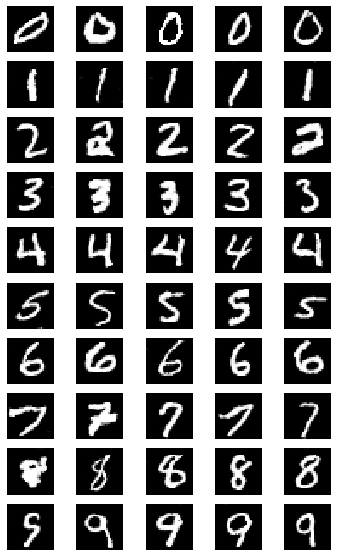

In [20]:
sample_images2(generator)

In [ ]:
for x in g_optim.state_dict():
    print(x)

In [14]:
generator.load_state_dict(torch.load("generator.pth"))

<All keys matched successfully>

In [15]:
discriminator.load_state_dict(torch.load('discriminator.pth'))

<All keys matched successfully>